In [152]:
{-# LANGUAGE OverloadedStrings, OverloadedLists, TypeFamilies, TypeApplications, FlexibleContexts #-}

import Math.AD.Data.Bracketing
import Math.AD.Real
import Control.Monad
import Data.Maybe (fromJust, maybe, maybeToList)
import Data.List.NonEmpty (toList, NonEmpty(..))
import Data.Foldable (minimumBy)
import Control.Lens
import IHaskell.Display
import Graphics.Rendering.Chart
import Graphics.Rendering.Chart.Easy
import Data.Traversable.Enumerate (enumMap)
import Text.LaTeX (LaTeX, (!:))

1 :-> 2

withPlaceholders :: Bracketing a -> Bracketing LaTeX
withPlaceholders x = enumMap f x 1 where
  f :: a -> Integer -> LaTeX
  f _ e = "F" !: fromInteger e

In [15]:
1 :-> 4

F (1 :-> 4) 10

1 :->:[(4,10), (5,20), (8, 100)]

Start
Tangent 1 Start
Adjoint Start 2
Preacc (Tangent 1 Start) (Adjoint Start 2)

:type fma
:type mem

zipFChain [32,32,16,8,4,1] $ repeat 50

I

fma :: forall a. FuncDescription a => Bracketing a -> Integer

mem :: forall a. FuncDescription a => Bracketing a -> Integer

# Listing multiple results

In [3]:
inputs :: [FChain']
inputs = f <$> [50] where
    f n = zipFChain [32,32,16,8,4,1] $ repeat n

In [2]:
pub :: FChain' -> IO ()
pub input = do
    printDisplay $ markdown "## New run"
    printDisplay $ display input
    printDisplay $ markdown "Results:"
    let res = bfEachBest fma mem input
    forM_ res (\r -> do
        printDisplay $ display r)

-- forM_ inputs pub

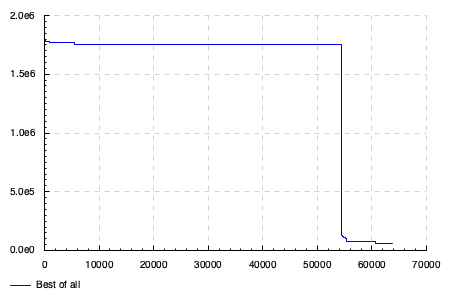

In [77]:
inx = testVal
res = bfEachBest fma mem inx

res

display.toRenderable.execEC $ plotRecs "Best of all" res


# Dynamic Program

In [158]:
testVal = zipFChain [8,1,4,1] $ [16,16,100]

withPlaceholders $ homTangent (toList $ unwrapFDesc testVal)

:type unwrapFDesc

mem :: FuncDescription a => Bracketing a -> Integer
mem Start = 0
mem (Tangent f Start) = inDim f
mem (Tangent f other) = mem other
mem (Adjoint Start f) = outDim f + edgeCount f
mem (Adjoint other f) = mem other + edgeCount f
mem (Preacc lhs rhs) = max (mem lhs) (mem rhs) + outDim lhs * inDim rhs

splitEach :: [a] -> [([a], [a])]
splitEach [] = []
splitEach [_] = []
splitEach xs = fmap (`splitAt` xs) [1..length xs-1]

unwrapFDesc :: forall a. CompDescription a => a -> NonEmpty FDesc'

In [159]:
dpFmaNaive :: CompDescription a => a -> Integer
dpFmaNaive input = dp 1 (length xs)
    where xs = toList $ unwrapFDesc input
          n i = inDim $ xs !! (i - 1)
          m i = outDim $ xs !! (i - 1)
          e i = edgeCount $ xs !! (i - 1)
          dp j i | j == i    = min (n i) (m j) * e i
                 | j < i     = dp i j
                 | otherwise = minimum $ concat [ dpCases j i k | k <- [i..j-1]]
          dpCases j i k = [ dp j (k+1) + dp k i + m j * m k * n i,
                            dp j (k+1) + m j * sum [e nu | nu <- [i..k]],
                            dp k i     + n i * sum [e nu | nu <- [k+1..j]]
                            ]

dpFmaNaive' :: CompDescription a => a -> Bracketing'
dpFmaNaive' input = dp (toList $ unwrapFDesc input)
    where -- xs = toList $ unwrapFDesc input
          minFma :: [Bracketing'] -> Bracketing'
          minFma xs = minimumBy (\x y -> fma x `compare` fma y) xs
          dp :: [FDesc'] -> Bracketing'
          dp []  = Start
          dp [x] = minFma [homTangent [x], homAdjoint [x]]
          dp xs = minFma $ concat [dpCases l r | (l,r) <- splitEach xs]
          dpCases :: [FDesc'] -> [FDesc'] -> [Bracketing']
          dpCases l r = [ Preacc (dp r) (dp l),
                          homTangent r <> dp l,
                          dp r <> homAdjoint l]

------------------------------------------------------------------------------------------------


filtMinFma :: Integer -> [Bracketing'] -> Maybe Bracketing'
filtMinFma c = minFma.filt c
    where minFma :: [Bracketing'] -> Maybe Bracketing'
          minFma [] = Nothing
          minFma xs = Just $ minimumBy (\x y -> fma x `compare` fma y) xs

          filt :: Integer -> [Bracketing'] -> [Bracketing']
          filt c = filter (\x -> mem x < c)

dp :: Integer -> [FDesc'] -> Maybe Bracketing'
dp c []  = Just Start
dp c [x] = filtMinFma c [homTangent [x], homAdjoint [x]]
dp c xs  = filtMinFma c (concatMap (dpCases c) (splitEach xs))

dpCases :: Integer -> ([FDesc'], [FDesc']) -> [Bracketing']
dpCases c (l,r) = [preaccCase c l r, tangentCase c l r, adjointCase c l r] >>= maybeToList

preaccCase :: Integer -> [FDesc'] -> [FDesc'] -> Maybe Bracketing'
preaccCase c l r = do
  let newConstraint = c - outDim (head l) * inDim (last r)
  lb <- dp newConstraint l
  rb <- dp newConstraint r
  return $ Preacc rb lb

tangentCase :: Integer -> [FDesc'] -> [FDesc'] -> Maybe Bracketing'
tangentCase c l r = do
  dl <- dp c l
  return $ homTangent r <> dl

adjointCase :: Integer -> [FDesc'] -> [FDesc'] -> Maybe Bracketing'
adjointCase c l r = do
  let dl = homAdjoint l
  let newConstraint = c - mem dl
  dr <- dp newConstraint r
  return $ dr <> dl

dpFmaMemNaive' :: CompDescription a => Integer -> a -> Maybe Bracketing'
dpFmaMemNaive' c input = dp c (toList $ unwrapFDesc input)

xs = toList $ unwrapFDesc testVal

x1 = head xs
x2 = last xs

res = fromJust $ adjointCase 30 [x1] [x2]

dpFmaNaive' testVal

fromJust $ bfBest fma mem Nothing testVal

res
fma res
mem res

-- bfEachBest fma mem testVal

816

17